In [32]:
import matplotlib.pyplot as plt
import pandas as pd
#import talib
import numpy as np
import lightgbm as lgb
import pyfolio as pf
import time
start_time = time.time()

In [33]:
#import tensorflow-gpu

In [34]:
import tensorflow as tf


In [35]:
print(len(tf.config.experimental.list_physical_devices('GPU')) )

0


In [36]:
from tensorflow.python.client import device_lib

In [37]:
print(device_lib.list_local_devices() )

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15256502639768397475
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 325265459252873470
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7334688637971658877
physical_device_desc: "device: XLA_GPU device"
]


In [38]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

In [39]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [40]:
#Step1 Get Original Data from Interactivebroker
filename = "quandl_N4N_5D_20071001~20200313.csv" #from IB
df = pd.read_csv(filename,index_col = 0)
# df.reset_index(drop=True,inplace=True)
print(df.shape)
print(df.head(1))
print(df.tail(1))

(5334, 21)
            SPF  DJF  Oil  GOLD  USD  TBF  TN5      SPFy  SPFclose  DJFy  ...  \
Date                                                                      ...   
2000-01-04  NaN  NaN  NaN   NaN  NaN  NaN  NaN  1.030103    1411.8   NaN  ...   

               GOLDy  GOLDclose      Oily  Oilclose      USDy  USDclose  \
Date                                                                      
2000-01-04  1.002664      281.5  1.008611     25.55  1.001598     100.1   

                TBFy  TBFclose      TN5y   TN5close  
Date                                                 
2000-01-04  0.984828    90.625  0.993776  97.914062  

[1 rows x 21 columns]
                 SPF       DJF       Oil  GOLD       USD       TBF       TN5  \
Date                                                                           
2020-06-12  0.008139  0.014743 -0.002201   NaN  0.005851 -0.006598 -0.000745   

            SPFy  SPFclose  DJFy  ...  GOLDy  GOLDclose  Oily  Oilclose  USDy  \
Date        

In [41]:
#Step2 check data

#Check NAN
print(df.isnull().values.any() )
print("before dropping NaN", df.shape)
df.dropna(inplace=True)
print("after dropping NaN", df.shape)

# print( df.info() )
print(type(df.index[0]), df.index[0])
df.index = pd.to_datetime(df.index)
# print( df.info() )
print(type(df.index[0]), df.index[0])

True
before dropping NaN (5334, 21)
after dropping NaN (3097, 21)
<class 'str'> 2007-10-02
<class 'pandas._libs.tslibs.timestamps.Timestamp'> 2007-10-02 00:00:00


In [42]:
print(df.head(1))

                 SPF       DJF       Oil      GOLD       USD       TBF  \
Date                                                                     
2007-10-02 -0.001285 -0.003602 -0.002368 -0.015488  0.005012  0.002515   

                 TN5      SPFy  SPFclose      DJFy  ...    GOLDy  GOLDclose  \
Date                                                ...                       
2007-10-02  0.001607  1.013894    1554.6  1.009287  ...  1.00684      731.0   

                Oily  Oilclose      USDy  USDclose      TBFy  TBFclose  \
Date                                                                     
2007-10-02  1.002623     80.05  1.002685      78.2  0.989116     112.0   

                TN5y    TN5close  
Date                              
2007-10-02  0.993437  107.140625  

[1 rows x 21 columns]


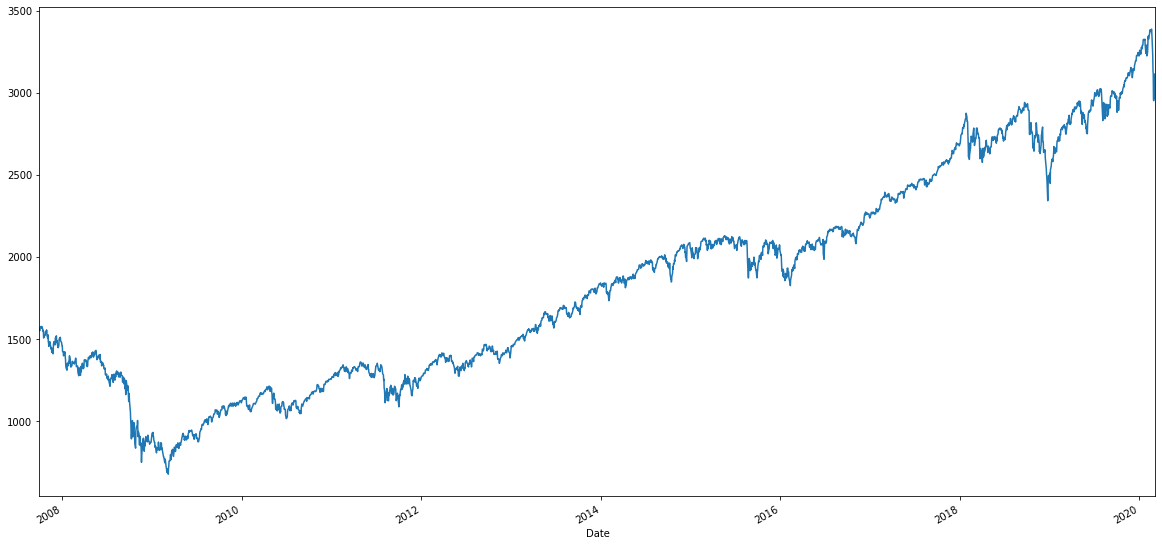

In [43]:
#Step Clean Data
tc=df.SPFclose #targetclose
plt.rcParams["figure.figsize"] = (20,10)
tc.plot()

In [44]:
# Feature 

In [45]:
dataset_scaled = df
feature_names = ['SPF','DJF','Oil','GOLD','USD','TBF','TN5']
y_names = ['SPFy','DJFy','Oily','GOLDy','USDy','TBFy','TN5y']
print(feature_names)
print(y_names)

['SPF', 'DJF', 'Oil', 'GOLD', 'USD', 'TBF', 'TN5']
['SPFy', 'DJFy', 'Oily', 'GOLDy', 'USDy', 'TBFy', 'TN5y']


In [46]:

%%time 
#Wall time: 4.09 s
import numpy as np
import tqdm

time_period = 200
days=5

cnn_x = []
cnn_y = []
indexs = []
for i in tqdm.tqdm_notebook(range(0, len(tc) - time_period -1 -days,3)): #- 1 - 10, 3)):
    #s = tc.iloc[i:i+time_period].values
    s = dataset_scaled[feature_names].iloc[i:i+time_period].values
    cnn_x.append((s - s.min())/(s.max() - s.min()))
    #r = tc.iloc[i+time_period+10] / tc.iloc[i+time_period-1]
    r = dataset_scaled[y_names].iloc[i+time_period+days]/dataset_scaled[y_names].iloc[i+time_period-1]
    cnn_y.append(r)
    #indexs.append(tc.index[i+time_period-1])
    indexs.append(dataset_scaled.index[i+time_period-1])
cnn_x = np.array(cnn_x)
cnn_y = np.array(cnn_y)
indexes = np.array(indexs)



CPU times: user 2.25 s, sys: 11.9 ms, total: 2.27 s
Wall time: 2.24 s


Reshape features and labels

In [47]:
cnn_x = cnn_x.reshape(len(cnn_x), time_period, 7) #1) #(1027,5,1)
cnn_y = cnn_y.reshape(len(cnn_y), 7) #1)          #(1027,1)
print(cnn_x.shape)
print(cnn_y.shape)

(1024, 20, 7)
(1024, 7)


In [48]:
import datetime
indexes

array([Timestamp('2007-10-30 00:00:00'), Timestamp('2007-11-05 00:00:00'),
       Timestamp('2007-11-08 00:00:00'), ...,
       Timestamp('2020-02-14 00:00:00'), Timestamp('2020-02-20 00:00:00'),
       Timestamp('2020-02-25 00:00:00')], dtype=object)

In [49]:
# import talib
# import numpy as np
# import pandas as pd

# sma = talib.SMA(tc, timeperiod=120)
# wma = talib.WMA(tc, timeperiod=120)
# mom = talib.MOM(tc, timeperiod=120)
# k, d = talib.STOCH  (tc, tc, tc, fastk_period=120, slowk_period=60, slowd_period=60)
# k2, d2 = talib.STOCH(tc, tc, tc, fastk_period=240, slowk_period=120, slowd_period=120)
# k3, d3 = talib.STOCH(tc, tc, tc, fastk_period=360, slowk_period=180, slowd_period=180)
# k4, d4 = talib.STOCH(tc, tc, tc, fastk_period=480, slowk_period=240, slowd_period=240)
# k5, d5 = talib.STOCH(tc, tc, tc, fastk_period=640, slowk_period=320, slowd_period=320)
# k6, d6 = talib.STOCH(tc, tc, tc, fastk_period=720, slowk_period=360, slowd_period=360)
# k7, d7 = talib.STOCH(tc, tc, tc, fastk_period=840, slowk_period=420, slowd_period=420)
# k8, d8 = talib.STOCH(tc, tc, tc, fastk_period=960, slowk_period=480, slowd_period=480)

# rsi = talib.RSI (tc, timeperiod=120)
# rsi2 = talib.RSI(tc, timeperiod=240)
# rsi3 = talib.RSI(tc, timeperiod=480)
# rsi4 = talib.RSI(tc, timeperiod=640)
# rsi5 = talib.RSI(tc, timeperiod=720)
# rsi6 = talib.RSI(tc, timeperiod=840)

# macd1, macd2, macd3 = talib.MACD(tc, fastperiod=120, slowperiod=60, signalperiod=60)
# willr = talib.WILLR(tc, tc, tc, timeperiod=120)
# cci = talib.CCI(tc, tc, tc, timeperiod=120)

# dataset = pd.DataFrame({
#     'RSIb': rsi / 50,
#     'RSIb2': rsi2 / 50,
#     'RSIb3': rsi3 / 50,
#     'RSIb4': rsi4 / 50,
#     'RSIb5': rsi5 / 50,
#     'RSIb6': rsi6 / 50,
#     'MOMb': mom - 0,
#     'KDb': k - d,
#     'KDb2': k2 - d2,
#     'KDb3': k3 - d3,
#     'KDb4': k4 - d4,
#     'KDb5': k5 - d5,
#     'KDb6': k6 - d6,
#     'KDb7': k7 - d7,
#     'KDb8': k8 - d8,
    
#     'a5':   (tc.rolling(5).mean()   / tc),
#     'a10':  (tc.rolling(10).mean()  / tc),
#     'a20':  (tc.rolling(20).mean()  / tc),
#     'a40':  (tc.rolling(40).mean()  / tc),
#     'a80':  (tc.rolling(80).mean()  / tc),
#     'a160': (tc.rolling(160).mean() / tc),
#     'a320': (tc.rolling(320).mean() / tc),
#     'a640': (tc.rolling(640).mean() / tc),
#     'a720': (tc.rolling(720).mean() / tc),
#     'a840': (tc.rolling(840).mean() / tc),
#     'a960': (tc.rolling(960).mean() / tc),
#     'a1024':(tc.rolling(1024).mean() / tc),
#     'b1': tc/tc.shift(50),
#     'b2': tc/tc.shift(100),
#     'b3': tc/tc.shift(150),
#     'b4': tc/tc.shift(200),
#     'b5': tc/tc.shift(250),
#     'b6': tc/tc.shift(300),
#     'b7': tc/tc.shift(350),
#     'LINEARREG_SLOPE0': talib.LINEARREG_SLOPE(tc, 60),
#     'LINEARREG_SLOPE1': talib.LINEARREG_SLOPE(tc, 120),

#     'ADXR0': talib.ADXR(tc, tc, tc, 60),
#     'ADXR1': talib.ADXR(tc, tc, tc, 120),
#     'ADXR2': talib.ADXR(tc, tc, tc, 240),
#     'ADXR3': talib.ADXR(tc, tc, tc, 360),
#     'ADXR4': talib.ADXR(tc, tc, tc, 480),
#     'ADXR5': talib.ADXR(tc, tc, tc, 640),

#     'return': tc.shift(-10) / tc,
# })

# feature_names = list(dataset.columns[:-1])

In [50]:
# print(feature_names)

In [51]:
#print("before dropping NaN", cnn_x.shape)
#cnn_x.dropna(inplace=True)
#print("after dropping NaN", cnn_x.shape)


Split traning and testing data


In [52]:
import datetime
cnn_x_train = cnn_x[indexes < datetime.datetime(2016,1,1)]
cnn_y_train = cnn_y[indexes < datetime.datetime(2016,1,1)]

In [53]:
print(cnn_x_train.shape) #
print(cnn_y_train.shape) #

(677, 20, 7)
(677, 7)


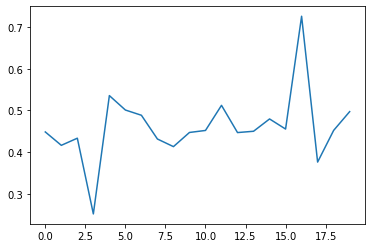

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
#cnn_X (1027,5,1)
plt.plot(cnn_x[0].reshape(7, len(cnn_x[0]))[0])


In [55]:
# CNN Preprocess

In [56]:
# from sklearn.preprocessing import StandardScaler
# ss = StandardScaler()
# dataset_scaled = ss.fit_transform(dataset[feature_names])
# dataset_scaled = pd.DataFrame(dataset_scaled, index=dataset.index, columns=feature_names)
# dataset_scaled['return'] = dataset['return']
# dataset_scaled.describe()

In [57]:
# CNN Model

In [58]:
%%time
#epoch 5 , %%time 

import keras.layers as layers
import keras
from keras.models import Sequential
from keras.initializers import he_normal

input_shape = cnn_x[0].shape
print(input_shape)
time_period = 20
num_classes = 1


model_m = Sequential()

model = keras.Sequential()

model.add(layers.Conv1D(filters=20, kernel_size=20, activation='relu', input_shape=cnn_x[0].shape))
model.add(layers.AveragePooling1D(5))

model.add(layers.Conv1D(filters=20, kernel_size=20, activation='relu'))
model.add(layers.AveragePooling1D(5))

# model.add(layers.Conv2D(filters=20, kernel_size=(20*1), activation='relu', input_shape=cnn_x[0].shape))
# model.add(layers.AveragePooling2D(5))

# model.add(layers.Conv2D(filters=20, kernel_size=(20*1), activation='relu'))
# model.add(layers.AveragePooling2D(5))
model.add(layers.Flatten())
model.add(layers.Dense(units=120, activation='relu'))
model.add(layers.Dense(units=84, activation='relu'))
model.add(layers.Dense(units= 7, ))  #1, ))#activation = 'softmax'))

adam = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.01, amsgrad=False)

model.compile(loss='mse',
                optimizer=adam)

print(model.summary())

get_best_model = keras.callbacks.ModelCheckpoint("N4N_cnn_300epoch.mdl", monitor="val_acc")


(20, 7)




ValueError: Negative dimension size caused by subtracting 5 from 1 for 'average_pooling1d_1/AvgPool' (op: 'AvgPool') with input shapes: [?,1,1,20].

In [59]:
#NN Training

In [60]:
%%time
#without GPU epoch  5 -> 
#without GPU epoch 50 ->  1min 26s
#without GPU epoch 100 -> Wall time: 2min 46s; GPU : 
#Without GPU epoch 200 -> : 5min 52s
#Without GPU epoch 300-> : 7min 52s
history = model.fit(cnn_x_train, cnn_y_train,
                    batch_size=200,
                    epochs=100,
                    verbose=1,
                    validation_split=0.1,
    callbacks=[get_best_model] )


NameError: name 'get_best_model' is not defined

In [61]:
# Verify

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.log(history.history['loss'][10:]),c='blue')
plt.plot(np.log(history.history['val_loss'][10:]),c='orange')

NameError: name 'history' is not defined

In [ ]:
print(len(history.history['loss']))     #200
print(len(history.history['val_loss'])) #200

In [ ]:
model.load_weights("N4N_cnn_300epoch.mdl")

In [ ]:
ey = model.predict(cnn_x)
ey = pd.Series(ey.swapaxes(0, 1)[0], index=indexes)

In [ ]:
eq = tc[pd.to_datetime(indexes)]

In [ ]:
gain = (eq.shift(-1) - eq) 
signal = (ey > ey.quantile(0.9)).rolling(20).sum() > 0


In [ ]:
eq = (gain[signal])['2016':].cumsum()

In [ ]:
eq.plot()

In [ ]:
eq.pct_change()[eq.pct_change() == eq.pct_change().max() ]

In [ ]:
signal['2016':].astype(int).diff().abs().sum()

In [ ]:
import pyfolio as pf 

In [ ]:
eq_relative = eq + tc[tc.index == eq.index[0]][0]
tw_relative = tc[eq.index[0]:]
plt.rcParams["figure.figsize"] = (20,10)
"""
        plt.rcParams["figure.figsize"] = (20,10)
        (hold*10).plot(label="hold")
        
        eq=creturn
        
        eq_relative = eq + tc[tc.index == eq.index[0]][0]
        bm_relative = tc[eq.index[0]:]

        eq_relative.plot(c="red",  label="BIAS strategy")
        bm_relative.plot(c="blue", label="Buy & Hold" )
        
#         creturn.plot(c="blue", label="BIAS strategy")
#         (tc-tc[0]).plot(c="red", label="Buy & Hold")
        plt.legend(loc='best')
"""
eq_relative.plot(c="red",  label="CNN strategy")
tw_relative.plot(c="blue", label="Buy & Hold")
plt.legend(loc='best')
eqpc = eq_relative.pct_change()
bmpc = tw_relative.pct_change() 

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
pf.create_returns_tear_sheet( eqpc, benchmark_rets=bmpc )  #relative

In [ ]:
print("My program took ", time.time()-start_time, "to run")